## 8. Multiclass Image Segmentation with DL

Outline

1. The Dataset
2. Loading all to memory
3. Flow from directory

In the previous notebook, you trained a U-Net for a single class. But what if there are multiple classes? One approach is to train a binary model for each class. This allows individual optimization for each class, which can be advantageous. Alternatively, you could train a single multiclass model, enabling it to learn inter-class relationships.

Both approaches have their pros and cons, so the best strategy is to try both and compare their performance to decide which works best for your use case.

In this notebook, I will adjust the network from the previous notebook to make it multi-class. We also need a dataset, as blood cell dataset is binary. I simulated a simple multi-class dataset for this purpose.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. The Dataset

To demonstrate the code, I wanted to create a very simple dataset. Each image contains a triangle and a rectangle. Masks are single channel labeled images where 0 is the background, 1 is the rectangle and 2 is the triangle.

In [2]:
def is_overlap(rect1, rect2):
    if (rect1[0] < rect2[0] + rect2[2]) and (rect1[0] + rect1[2] > rect2[0]) and \
       (rect1[1] < rect2[1] + rect2[3]) and (rect1[1] + rect1[3] > rect2[1]):
        return True
    return False

def generate_non_overlapping_rect(existing_rects, max_attempts=100):
    for _ in range(max_attempts):
        x, y = np.random.randint(20, 44, size=2)
        size = np.random.randint(10, 20)
        new_rect = (x, y, size, size)
        if not any(is_overlap(new_rect, rect) for rect in existing_rects):
            return new_rect
    return None

def generate_dataset(num_images, output_dir, dataset_type):
    for subdir in [f'{dataset_type}_images/{dataset_type}', f'{dataset_type}_masks/{dataset_type}']:
        os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)
    
    for i in range(num_images):
        image = np.zeros((64, 64, 3), dtype=np.uint8)
        mask = np.zeros((64, 64), dtype=np.uint8)
        existing_rects = []

        # Generate a rectangle
        rect = generate_non_overlapping_rect(existing_rects)
        if rect is not None:
            x, y, size, _ = rect
            existing_rects.append(rect)
            image = cv2.rectangle(image, (x, y), (x + size, y + size), (255, 255, 255), -1)
            mask = cv2.rectangle(mask, (x, y), (x + size, y + size), 1, -1)

        # Generate a triangle
        rect = generate_non_overlapping_rect(existing_rects)
        if rect is not None:
            x, y, size, _ = rect
            points = np.array([[x, y], [x + size, y], [x, y + size]], np.int32)
            image = cv2.fillConvexPoly(image, points, (255, 255, 255))
            mask = cv2.fillConvexPoly(mask, points, 2)

        cv2.imwrite(f'{output_dir}/{dataset_type}_images/{dataset_type}/{i}.png', image)
        cv2.imwrite(f'{output_dir}/{dataset_type}_masks/{dataset_type}/{i}.png', mask)

In [3]:
# when you run this block
# it will create a folder where the notebook is
# and populate it with the dataset
output_dir = 'shapes_dataset'

generate_dataset(500, output_dir, 'train')
generate_dataset(100, output_dir, 'val')

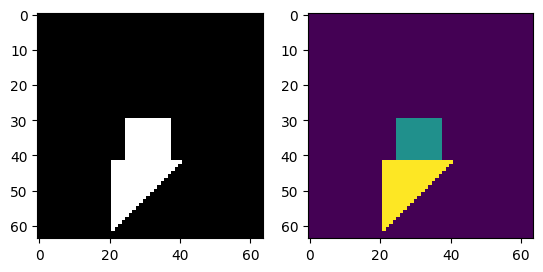

In [4]:
example_image = cv2.imread('shapes_dataset/train_images/train/0.png')
example_mask = cv2.imread('shapes_dataset/train_masks/train/0.png', 0) # read it as grayscale
fig, ax = plt.subplots(1, 2)
ax[0].imshow(example_image)
ax[1].imshow(example_mask)

In [5]:
np.unique(example_image)

array([  0, 255], dtype=uint8)

In [6]:
np.unique(example_mask)

array([0, 1, 2], dtype=uint8)

## 2. Loading all to memory

In [7]:
import tensorflow as tf
import keras.backend as K

In [8]:
# SAME AS NOTEBOOK 7
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
# *AlMOST* SAME AS NOTEBOOK 7
# Diff 1: output layer Conv2D(n_classes, (1, 1), activation='softmax')(c9)
# Diff 2: loss='categorical_crossentropy'
# Diff 3: multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes)

# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes): # changed
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9) # changed
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1]) # changed
    model.summary()
    
    return model

In [10]:
model = multiclass_unet_model(64, 64, 3, n_classes=3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 64, 64, 16)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 16)           2320      ['dropout[0][0]']             
                                                                                              

In [11]:
import glob
X_train = []
y_train = []
for im_path in glob.glob('shapes_dataset/train_images/train/*.png'):
    mask_path = im_path.replace('images', 'masks')
    im = cv2.imread(im_path)
    mask = cv2.imread(mask_path, 0)
    X_train.append(im)
    y_train.append(mask)

X_val = []
y_val = []
for im_path in glob.glob('shapes_dataset/val_images/val/*.png'):
    mask_path = im_path.replace('images', 'masks')
    im = cv2.imread(im_path)
    mask = cv2.imread(mask_path, 0)
    X_val.append(im)
    y_val.append(mask)

In [12]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((500, 64, 64, 3), (500, 64, 64), (100, 64, 64, 3), (100, 64, 64))

**Correct mask format for multiclass UNet**

One important point is, you need to convert the masks to categorical. Currently it is one channel with all the labels (0, 1, 2). But similar to multiclass classification, we should preprocess this into (1, 0, 0) (0, 1, 0) and (0, 0, 1). You can think of this as color channels, where instead of colors we have binary label masks in each channel.

In [13]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_train.shape, y_val.shape

((500, 64, 64, 3), (100, 64, 64, 3))

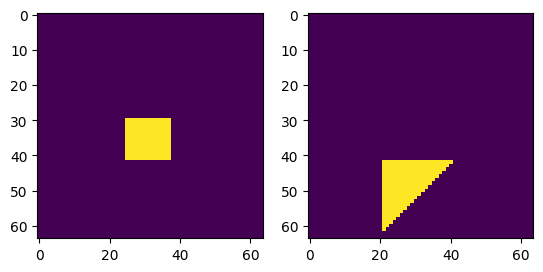

In [14]:
# Demo of the output format
example_mask = y_train[0]
rectangle_channel = example_mask[:, :, 1]
triangle_channel = example_mask[:, :, 2]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(rectangle_channel)
ax[1].imshow(triangle_channel)

Note: I did not normalize the input images. Normally you should. But because this is a simple dataset, it will still work.

In [15]:
# SAME AS NOTEBOOK 7
from keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor='val_loss',
                   patience=2,
                   restore_best_weights='True',
                   mode='min')

history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[cb])

Epoch 1/100
32/32 [==============================] - 9s 207ms/step - loss: 8.7356 - accuracy: 0.7356 - f1: 0.6873 - val_loss: 0.4699 - val_accuracy: 0.9619 - val_f1: 0.9554
Epoch 2/100
32/32 [==============================] - 7s 214ms/step - loss: 0.5798 - accuracy: 0.9445 - f1: 0.9509 - val_loss: 0.1166 - val_accuracy: 0.9320 - val_f1: 0.9572
Epoch 3/100
32/32 [==============================] - 6s 202ms/step - loss: 0.1836 - accuracy: 0.9303 - f1: 0.9556 - val_loss: 0.0920 - val_accuracy: 0.9303 - val_f1: 0.9607
Epoch 4/100
32/32 [==============================] - 6s 189ms/step - loss: 0.1375 - accuracy: 0.9310 - f1: 0.9586 - val_loss: 0.0833 - val_accuracy: 0.9334 - val_f1: 0.9628
Epoch 5/100
32/32 [==============================] - 6s 192ms/step - loss: 0.1180 - accuracy: 0.9437 - f1: 0.9606 - val_loss: 0.0776 - val_accuracy: 0.9806 - val_f1: 0.9642
Epoch 6/100
32/32 [==============================] - 6s 193ms/step - loss: 0.1043 - accuracy: 0.9764 - f1: 0.9618 - val_loss: 0.0728 - 

Let's take a look at example predictions:

In [16]:
# SAME AS NOTEBOOK 7
predicted_masks = model.predict(X_val)

4/4 [==============================] - 0s 48ms/step


In [17]:
# The output has channels where each channel is a class
predicted_masks.shape

(100, 64, 64, 3)

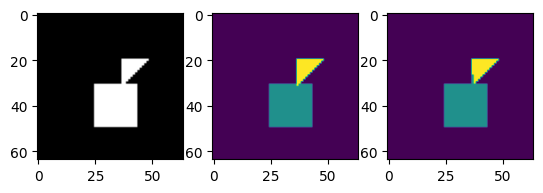

In [18]:
# We need to do argmax to get predicted labels
i = 2
prediction = np.argmax(predicted_masks[i], axis=2)
ground_truth = np.argmax(y_val[i], axis=2)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_val[i])
ax[1].imshow(ground_truth)
ax[2].imshow(prediction)

In [19]:
# Back to the original shape
prediction.shape

(64, 64)

## 3. Flow from directory

Now this part is also very similar to Notebook 7. The only issue is we need to add the `to_categorical` step.

`ImageDataGenerator()` has a parameter called `preprocessing_function` but the documentation says

>The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.

Which means it won't allow `to_categorical` because it changes the shape of the array. So I used a custom generator:

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def custom_generator(dataset_type, batch_size, target_size):
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        f'shapes_dataset/{dataset_type}_images',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        seed=42)

    mask_generator = mask_datagen.flow_from_directory(
        f'shapes_dataset/{dataset_type}_masks',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        color_mode='grayscale',
        seed=42)
    
    # Here I can add the to_categorical part
    while True:
        X = image_generator.next()
        Y = mask_generator.next()
        Y = to_categorical(Y, num_classes=3)  # Convert masks to categorical
        yield X, Y

In [21]:
train_gen = custom_generator('train', batch_size=32, target_size=(64, 64))
val_gen = custom_generator('val', batch_size=32, target_size=(64, 64))

In [22]:
model = multiclass_unet_model(64, 64, 3, n_classes=3)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 64, 64, 16)           448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 64, 64, 16)           0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 64, 64, 16)           2320      ['dropout_9[0][0]']           
                                                                                            

In [23]:
# I am cheating here a little
# Generators have an attribute to get dataset size
# but since I wrote a custom one, I did not implement such attributes
# I am simply checking the size from X_train/X_val, but you can check it without loading images to memory
num_of_train_images = X_train.shape[0]
num_of_val_images = X_val.shape[0]

In [24]:
# SAME AS NOTEBOOK 7
cb = EarlyStopping(monitor='val_loss',
                   patience=2,
                   restore_best_weights='True',
                   mode='min')

history = model.fit(
    train_gen,
    steps_per_epoch = num_of_train_images//32,
    epochs=100,
    validation_data = val_gen,
    validation_steps = num_of_val_images//32,
    callbacks=[cb]
)

Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 4.5224 - accuracy: 0.9085 - f1: 0.9079Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
15/15 [==============================] - 7s 325ms/step - loss: 4.5224 - accuracy: 0.9085 - f1: 0.9079 - val_loss: 0.5112 - val_accuracy: 0.9689 - val_f1: 0.9632
Epoch 2/100
15/15 [==============================] - 4s 304ms/step - loss: 0.5110 - accuracy: 0.9592 - f1: 0.9589 - val_loss: 0.2223 - val_accuracy: 0.9746 - val_f1: 0.9743
Epoch 3/100
15/15 [==============================] - 4s 296ms/step - loss: 0.2525 - accuracy: 0.9632 - f1: 0.9633 - val_loss: 0.0976 - val_accuracy: 0.9775 - val_f1: 0.9770
Epoch 4/100
15/15 [==============================] - 4s 292ms/step - loss: 0.1674 - accuracy: 0.9638 - f1: 0.9642 - val_loss: 0.0648 - val_accuracy: 0.9792 - val_f1: 0.9788
Epoch 5/100
15/15 [==============================

In [25]:
predicted_masks = model.predict(X_val)
predicted_masks.shape

4/4 [==============================] - 0s 49ms/step


(100, 64, 64, 3)

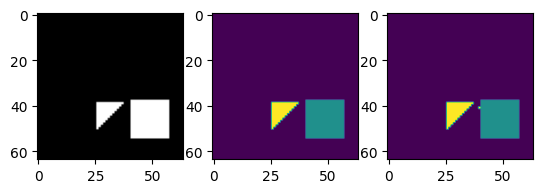

In [26]:
i = 0
prediction = np.argmax(predicted_masks[i], axis=2)
ground_truth = np.argmax(y_val[i], axis=2)
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_val[i])
ax[1].imshow(ground_truth)
ax[2].imshow(prediction)